In [1]:
import numpy as np
import sys
import pyvista as pv
import os
import torch
import matplotlib.pyplot as plt

In [2]:
class IGBReader:
    """ 
    class IGBReader: reads an igb file
    """
    
    def __init__(self):
        self.__header: dict     = None
        self.__data: np.ndarray = None
        self.__filename: str    = None
        self.__ndiff: int       = 0
        self.__head_size: int   = 256

    def read(self,igbfname: str):
        """ read(igbfname):
        reads the IGB file igbfname and fills the header and data attributes.
        """
        self.__filename = igbfname
        try:
            parsed_header = self.__parse_header()

            #now read the data and create an array        
            with open(self.__filename,'rb') as f:
                y = np.fromfile(f,'f4')
            y        = y[self.__head_size:]
            nt       = parsed_header['t']
            nx       = parsed_header['x']            
            nentries = y.shape[0]
            ntot     = nt*nx
            self.__ndiff = nentries-ntot
            
            if(nentries>ntot):
                # More values than expected
                print('Warning: problem with the igb file',flush=True)
                print('Discarding the last {} elements'.format(self.__ndiff))
                y  = y[:ntot] 
            elif(nentries<ntot):  
                #less values than expected nentries<ntot
                nt = nentries//nx
                if(nt==0):
                    print('ERROR: y too short!')
                    print('({} elements; expected {} (problems with the igb file)'.format(nentries,ntot))
                    sys.exit()
                else:
                    ntot     = nt*nx
                    y        = y[:ntot]
                    missing = nentries%nx
                    print('Warning: problem with the ifgb file',flush=True)                    
                    print('Missing {} elements to reach {}'.format(missing,parsed_header['t'])) 
                    print('Reshaping to {} time steps'.format(nt))
            else:
                print('file is ok')
            parsed_header['t'] = nt
            y = np.reshape(y,(nt,nx))
            self.__header = parsed_header
            self.__data   = np.copy(y)
        except ValueError:
            print('error with {0}'.format(self.__filename) )


    def header(self) ->dict :
        """header(): returns the header dict"""
        return(self.__header)

    def data(self) ->np.ndarray :
        """data(): returns the numpy array that contains the data"""
        return(self.__data)

    def filename(self) ->str :
        """filename(): returns the file name that contained the data"""
        return(self.__filename)

    def ndiff(self) ->int :
        """ndiff(): returns the number of entries in excess/missing in the original file"""
        return(self.__ndiff)

    def org_t(self) ->float:
        """org_t(): returns the time origin"""
        return(self.__header['org_t'])
        
    def nt(self) -> int:
        """nt(): returns the total number of time steps"""
        return(self.__header['t'])
    
    def nx(self) -> int:
        """nx(): returns the x space dimension"""
        return(self.__header['x'])

    def ny(self) -> int:
        """ny(): returns the y space dimension"""
        return(self.__header['y'])

    def nz(self) -> int:
        """nz(): returns the z space dimension"""
        return(self.__header['z'])

    def dim_t(self) ->float:
        """dim_t(): returns the temporal dimension""" 
        return(self.__header['dim_t'])
    
    def dt(self) ->float:
        """dt(): returns the time step (nan if nt=1)"""
        if(self.nt()>1):
            return(self.dim_t()/(self.nt()-1))
        else:
            return(np.nan)

    def timevalues(self,shifted:bool = False) ->np.ndarray:
        """timevalues(shifted=False): returns a numpy array with the time axis
        if shifted = True, it shifts the time values to have 0 as the first one
        """
        tline = self.dt()*np.arange(self.nt())
        if shifted:
            return(tline)
        else:
            return(self.org_t()+tline)


    def __parse_header(self) ->dict :
        ''' parse_header():
        parses the header of the IGB file.
        '''
        parsed_header = {}
        int_keys = ['x','y','z','t']
        try:
            with open(self.__filename,'rb') as f:
                header = f.read(self.__head_size)
            header = header.decode("utf-8")
            for jj in header.strip().split():
                [key,val]=jj.split(':')
                if(val.isdigit()):
                    if key in int_keys:
                        parsed_header[key]=int(val)
                    else:
                        parsed_header[key]=float(val)
                else:
                    parsed_header[key]=val            
            # Now add some keys that might miss
            if not 'y' in parsed_header.keys():
                parsed_header['y'] = int(1)            
            if not 'z' in parsed_header.keys():
                parsed_header['z'] = int(1)
            if not 'org_t' in parsed_header.keys():
                parsed_header['org_t'] = float(0)
            if not 'dim_t' in parsed_header.keys():
                parsed_header['dim_t'] = float(parsed_header['t']-1 )
            if not 'unites_x' in parsed_header.keys():
                parsed_header['unites_x'] = 'unk'
            if not 'unites_y' in parsed_header.keys():
                parsed_header['unites_y'] = 'unk'
            if not 'unites_z' in parsed_header.keys():
                parsed_header['unites_z'] = 'unk'
            if not 'unites_t' in parsed_header.keys():
                parsed_header['unites_t'] = 'unk'
            if not 'unites' in parsed_header.keys():
                parsed_header['unites'] = 'unk'
            if not 'facteur' in parsed_header.keys():
                parsed_header['facteur'] = 1
            if not 'zero' in parsed_header.keys():
                parsed_header['zero'] = 0
            return(parsed_header)
                                  
        except Exception as err:
            print(f"Unexpected {err=}, {type(err)=}")
            raise

In [3]:
reader = IGBReader()
reader.read("/home/bzhou6/Downloads/vm.igb")
carp_solution = reader.data()[1: -1]

cor_solution = torch.load("/home/bzhou6/Downloads/Vm.pt").numpy()

file is ok


In [4]:
cor_solution.shape

(599, 637480)

In [5]:
carp_solution.shape

(599, 637480)

In [6]:
# np.argsort(np.sum(carp_solution - cor_solution, axis=1))[-1]

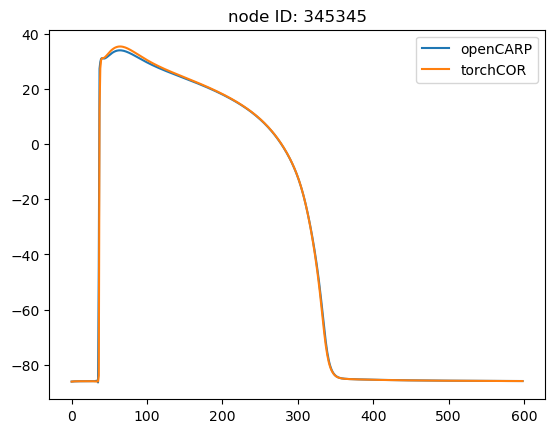

In [7]:
carp = []
cor = []
largest_diff_node = 345345
for i in range(599):
    carp.append(carp_solution[i][largest_diff_node])
    cor.append(cor_solution[i][largest_diff_node])
    
plt.plot(carp, label="openCARP")
plt.plot(cor, label="torchCOR")
plt.title(f"node ID: {largest_diff_node}")
plt.legend()

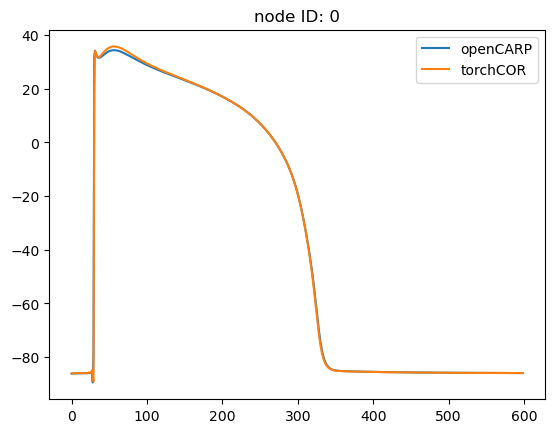

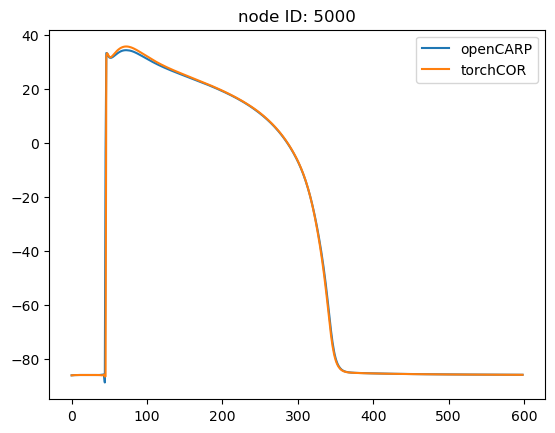

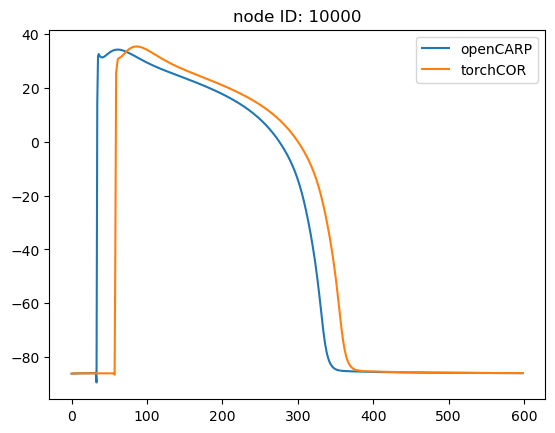

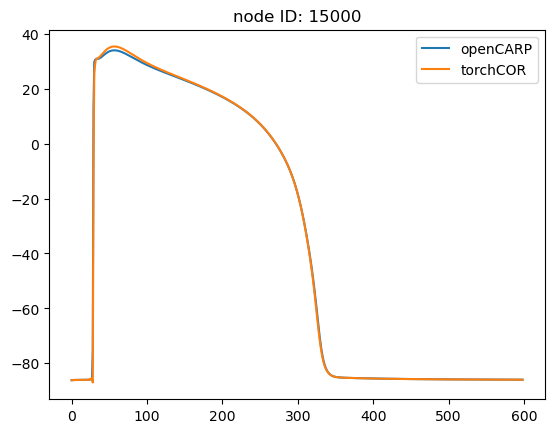

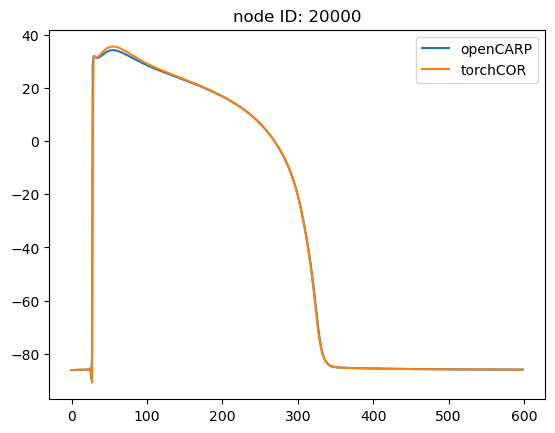

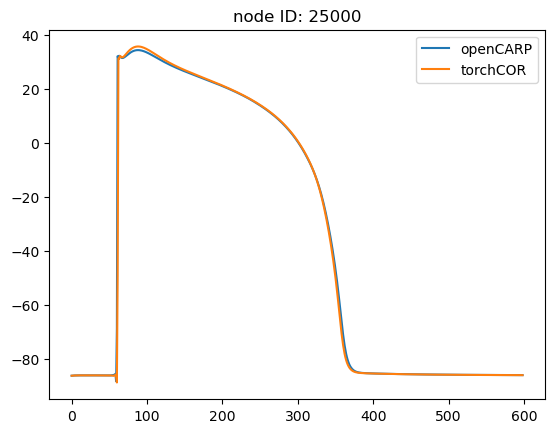

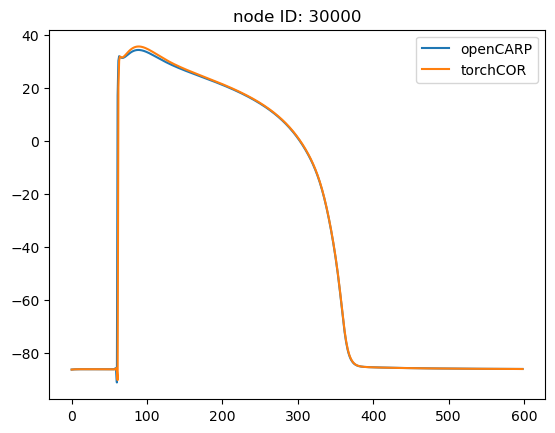

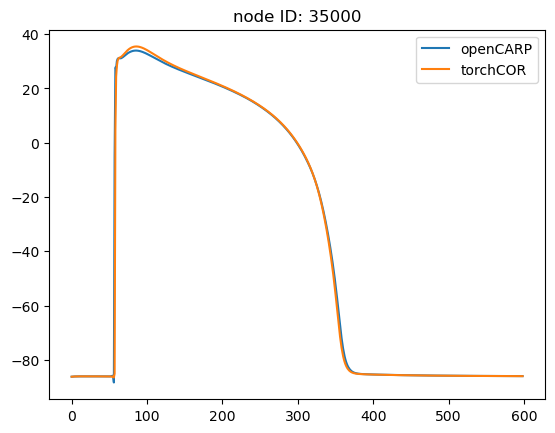

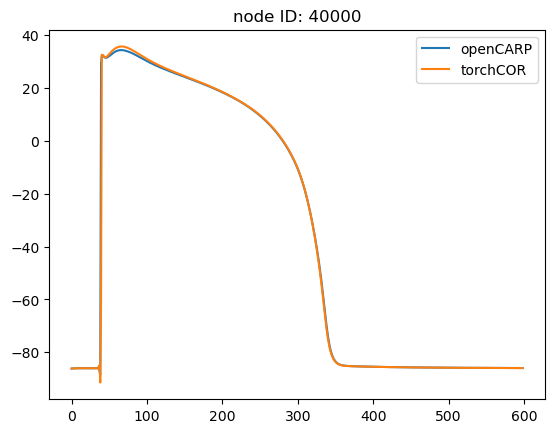

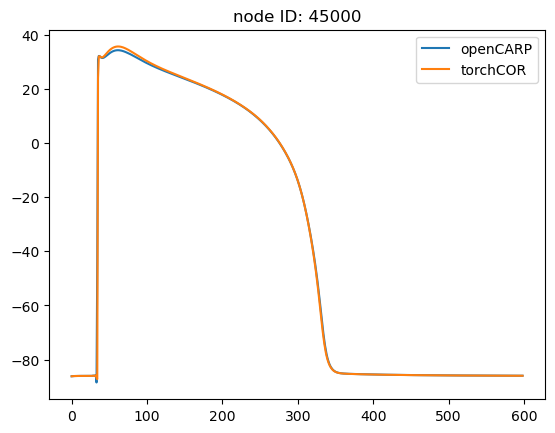

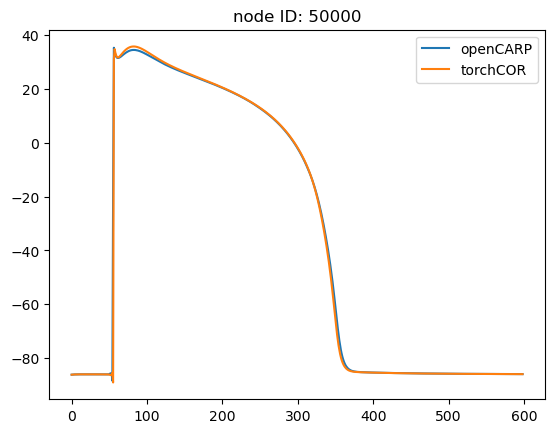

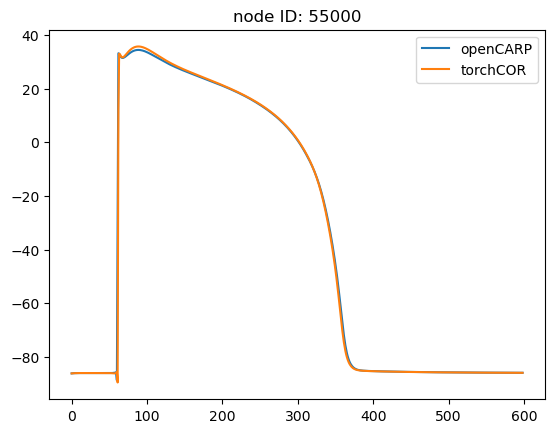

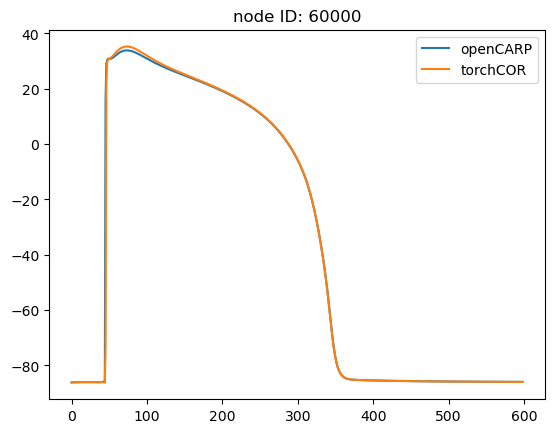

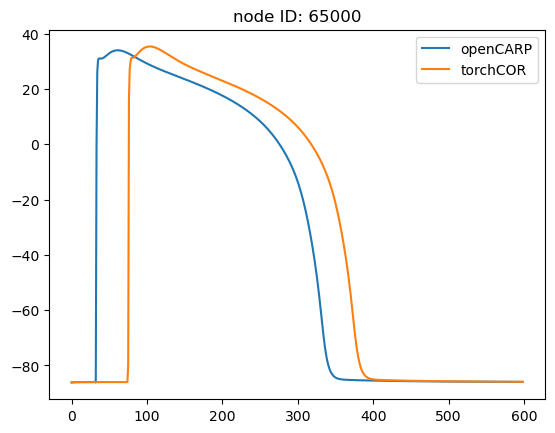

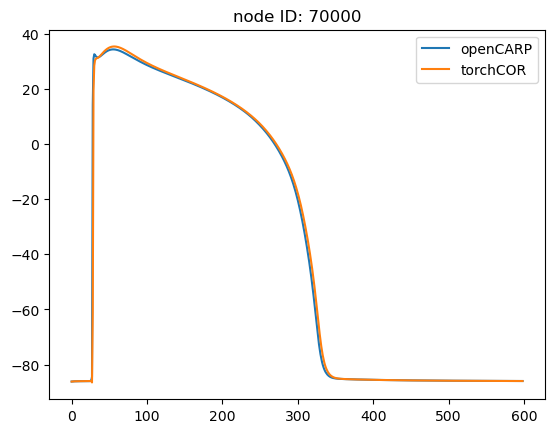

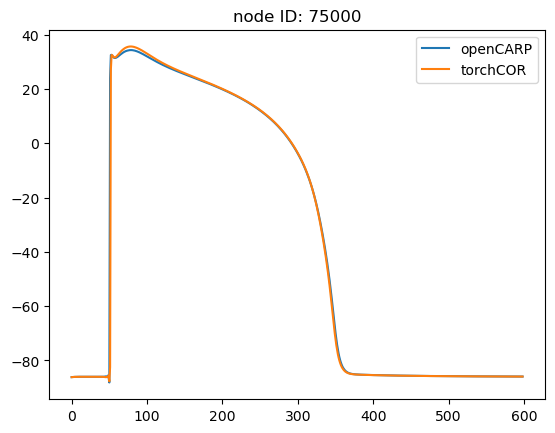

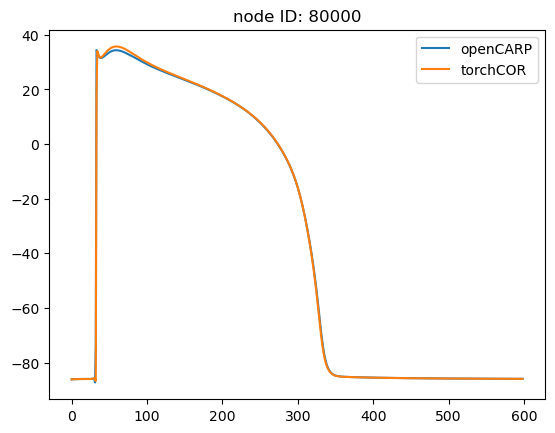

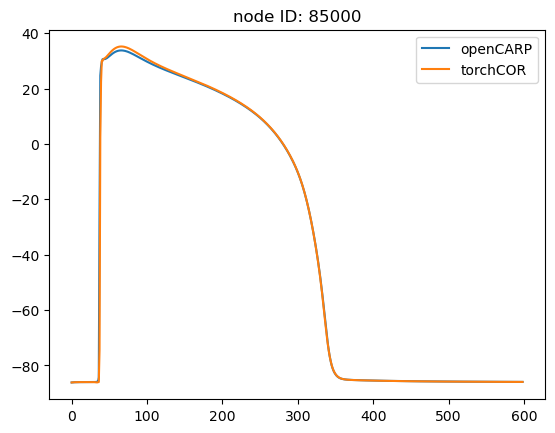

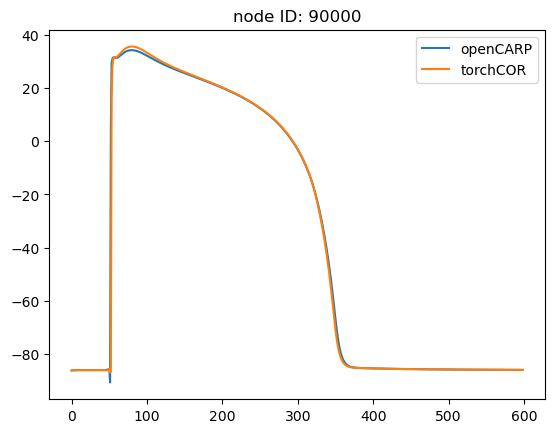

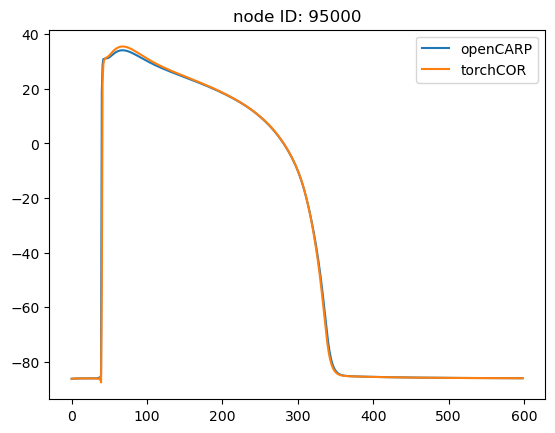

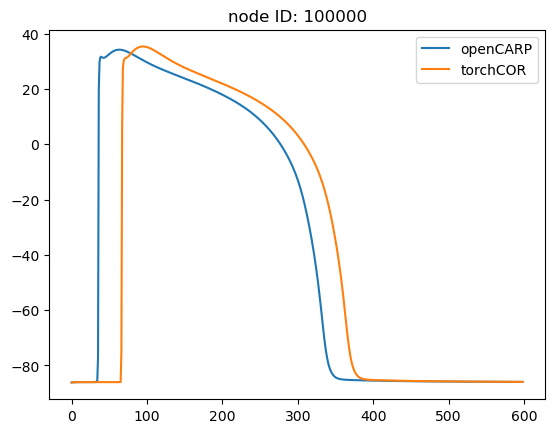

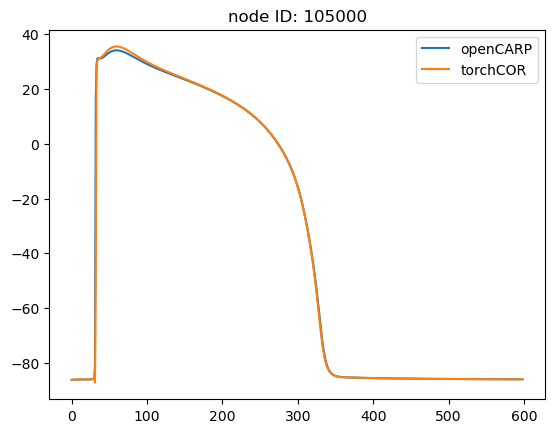

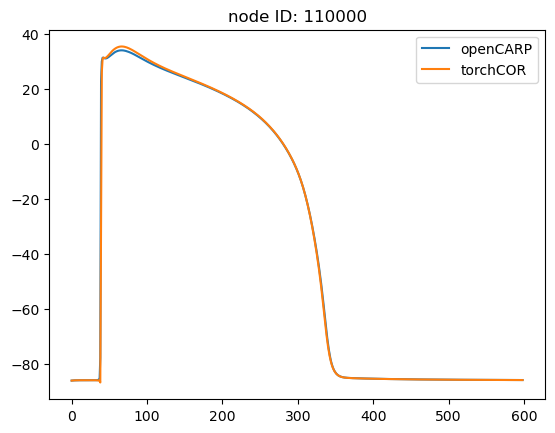

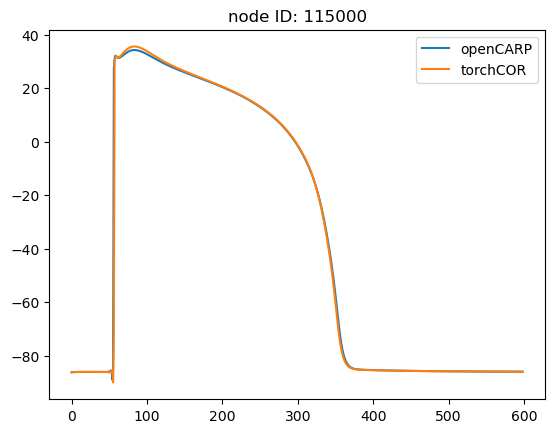

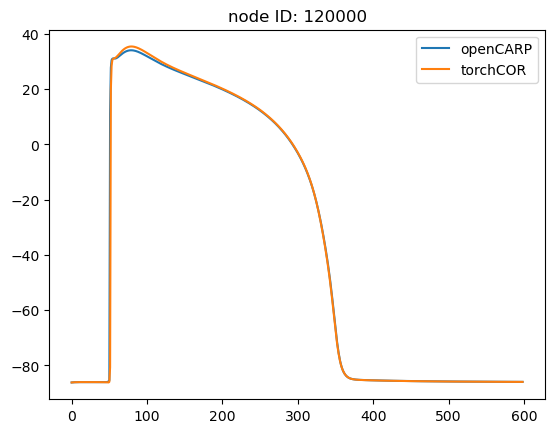

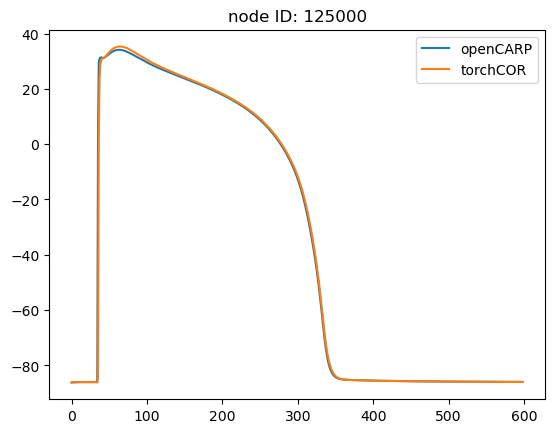

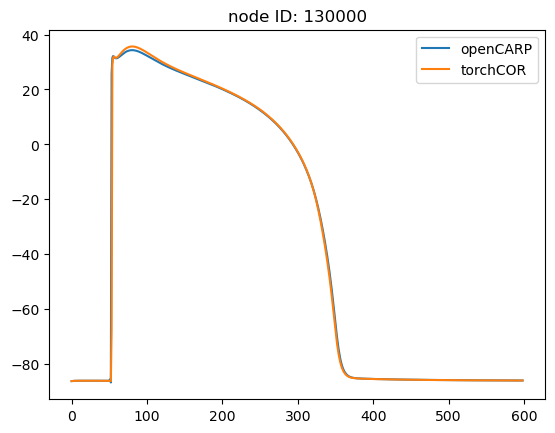

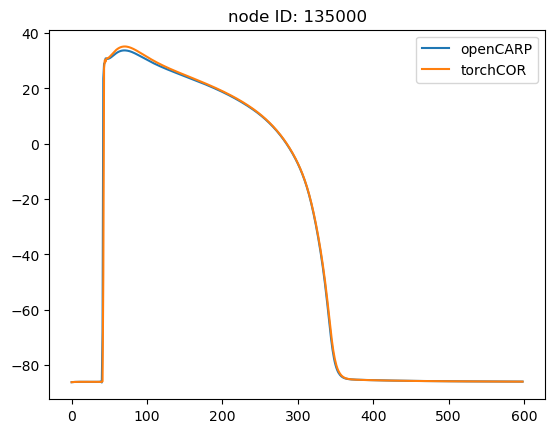

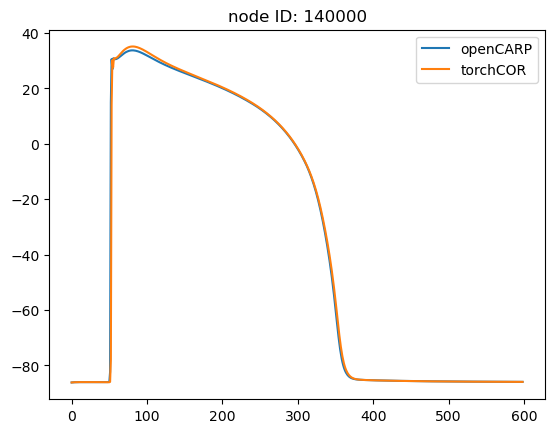

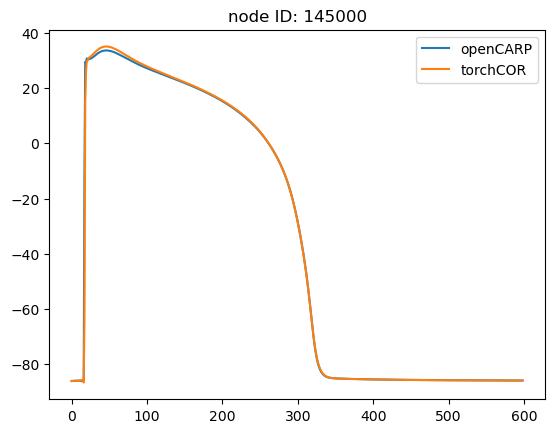

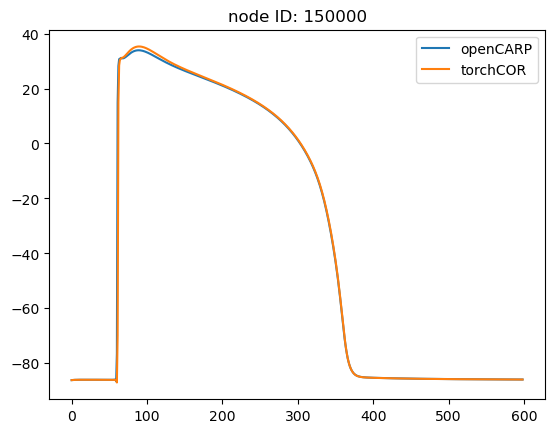

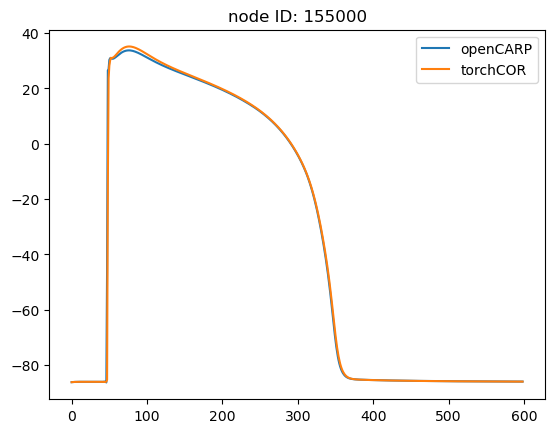

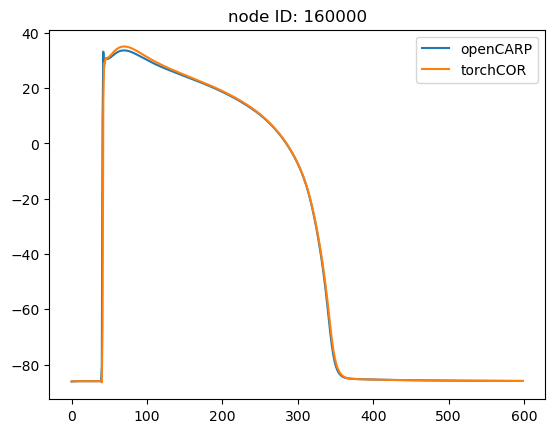

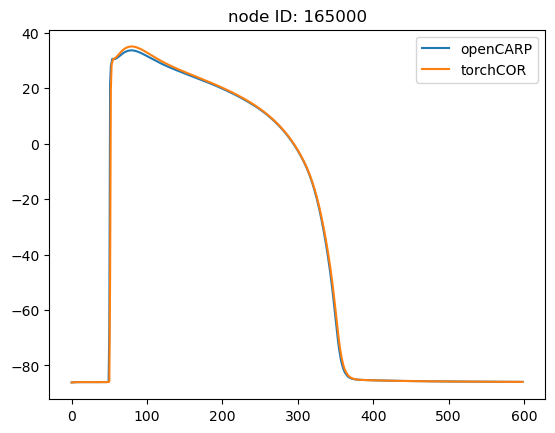

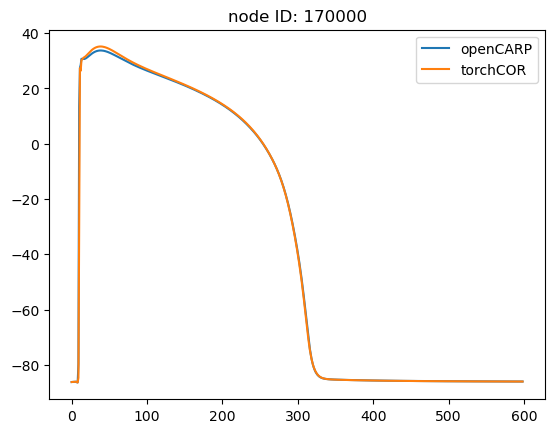

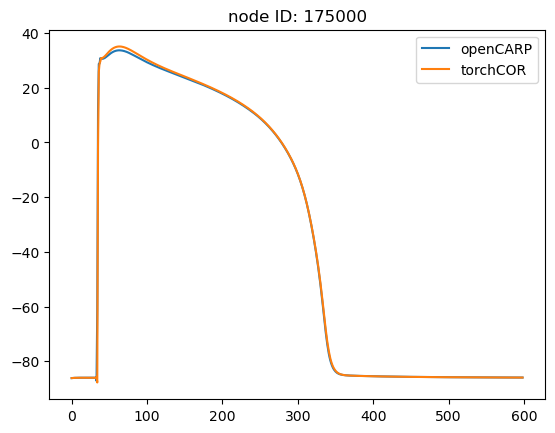

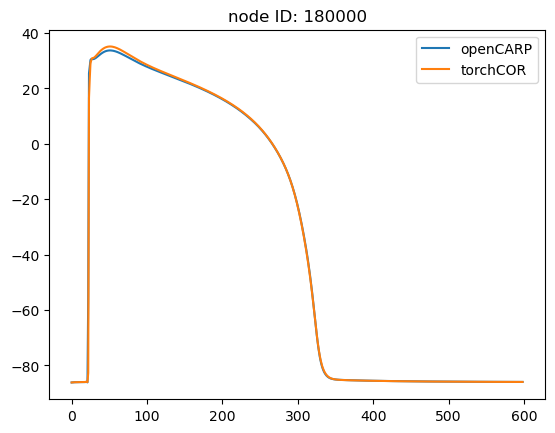

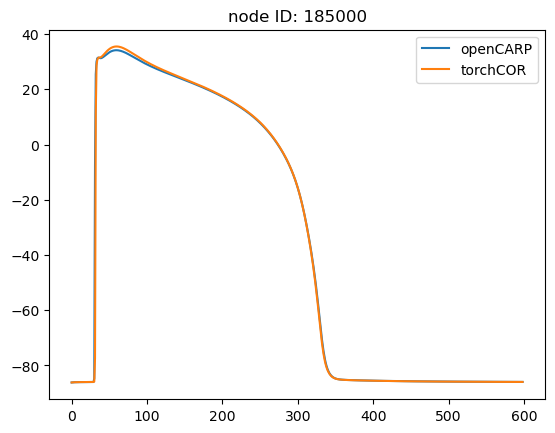

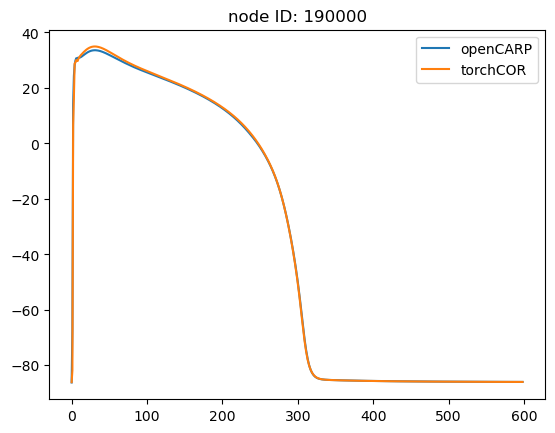

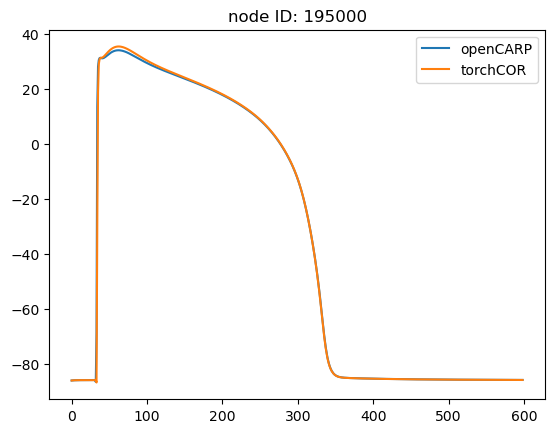

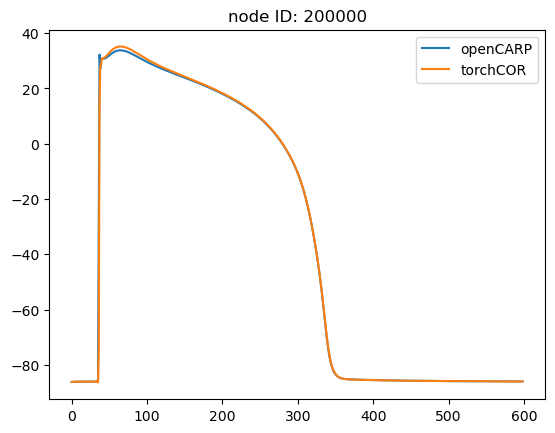

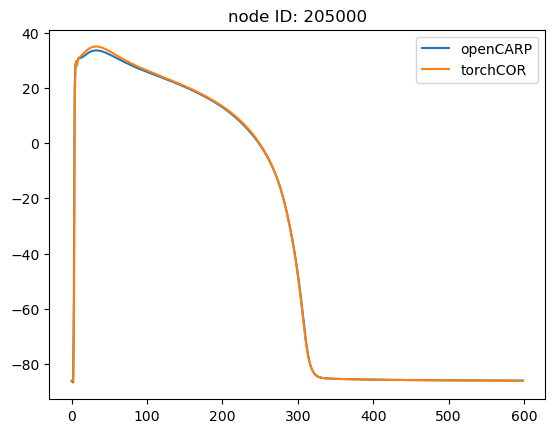

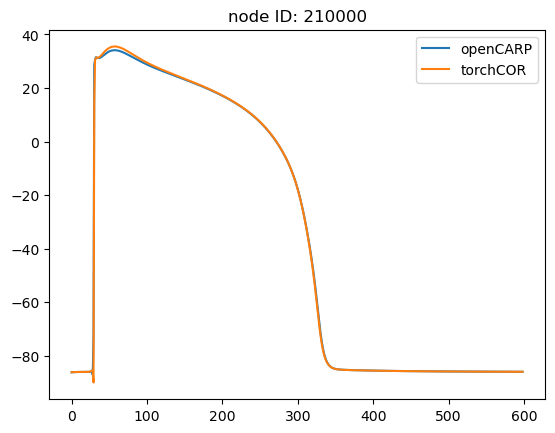

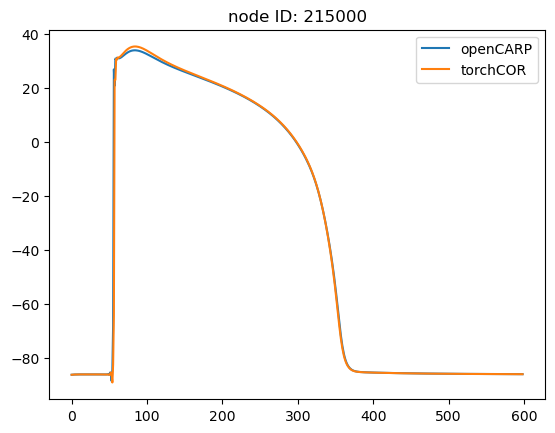

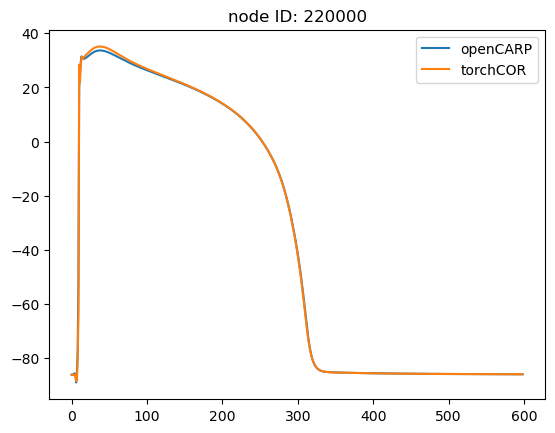

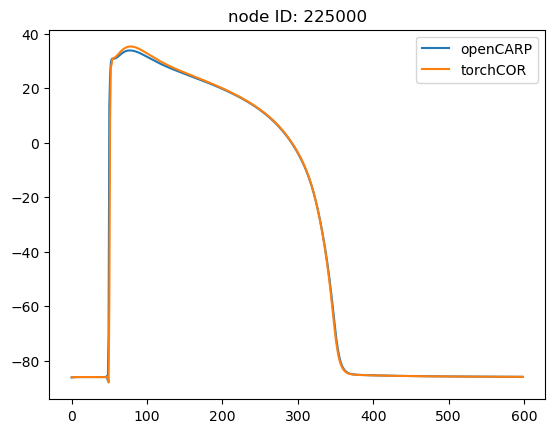

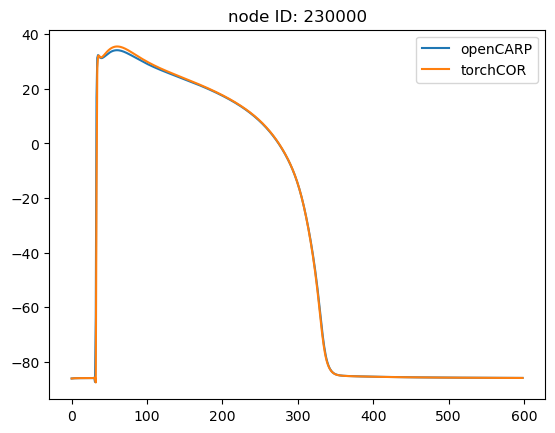

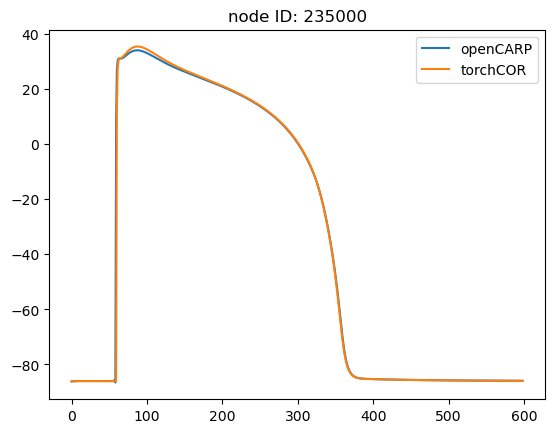

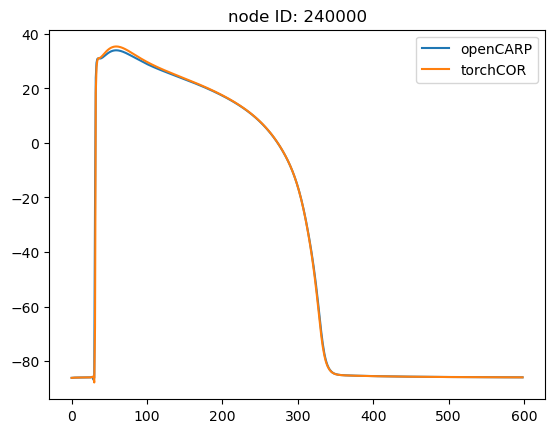

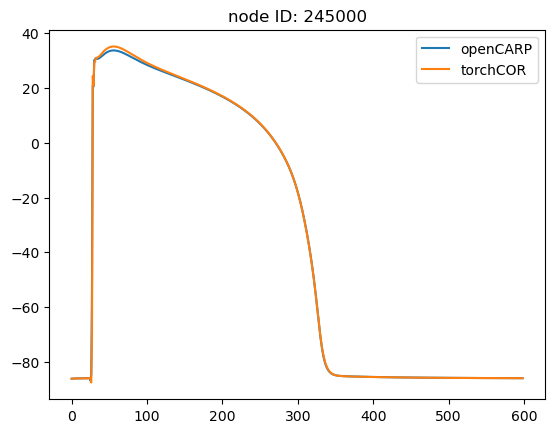

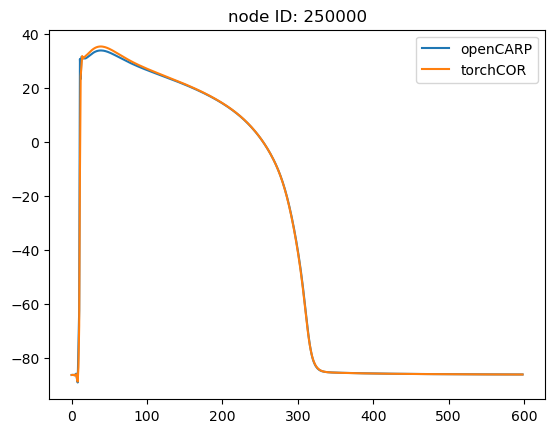

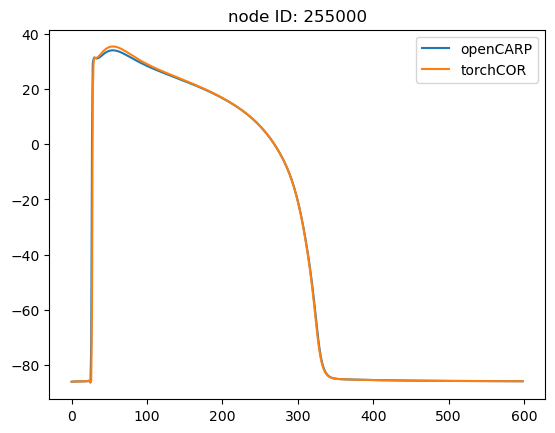

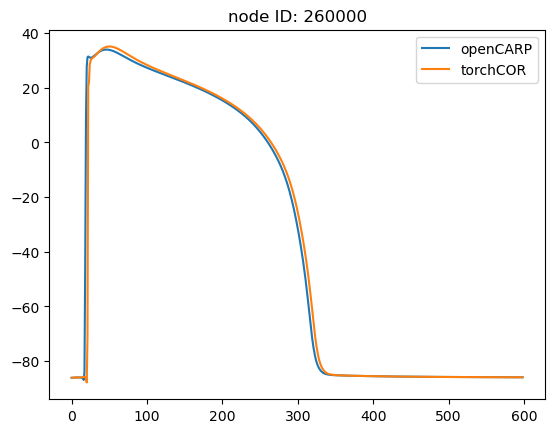

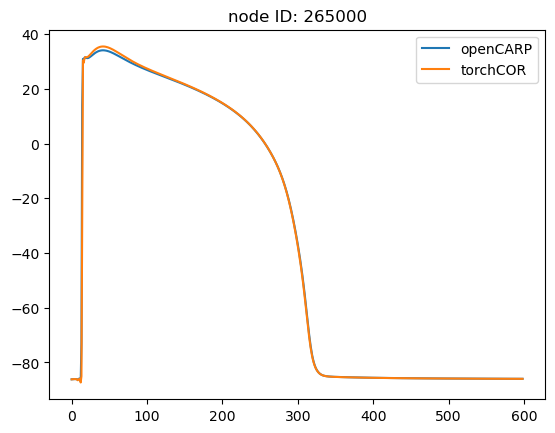

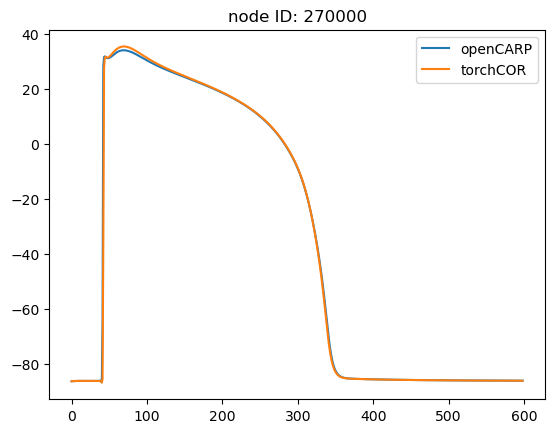

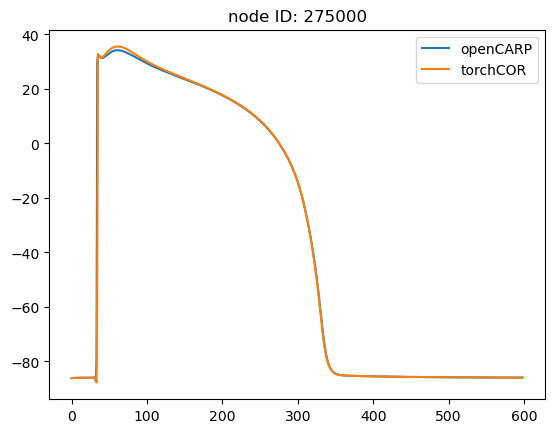

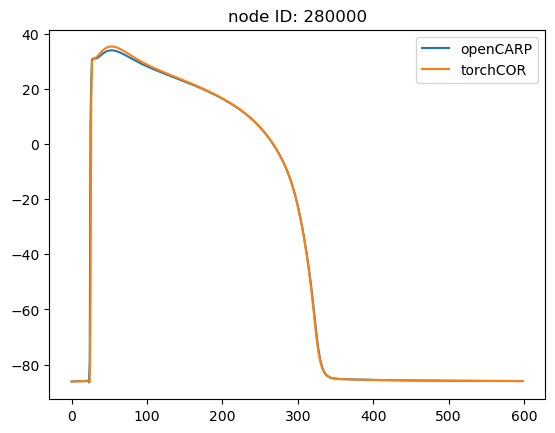

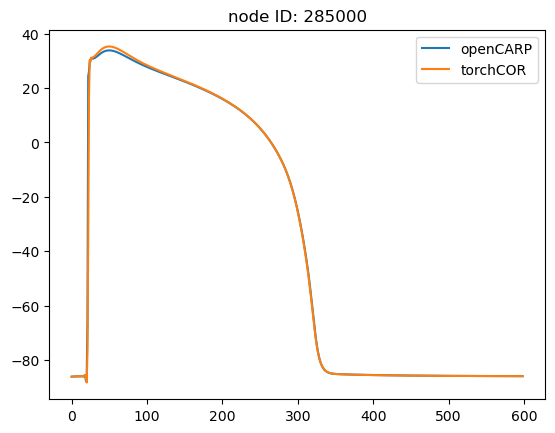

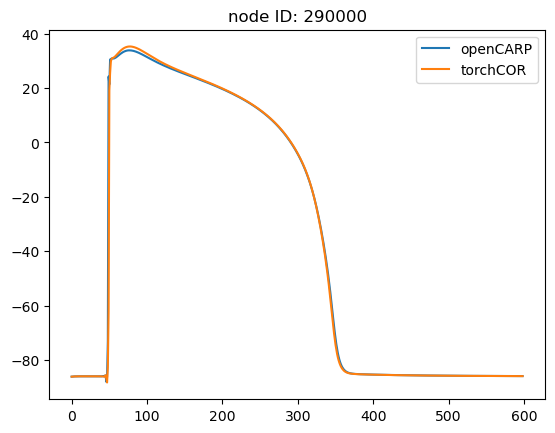

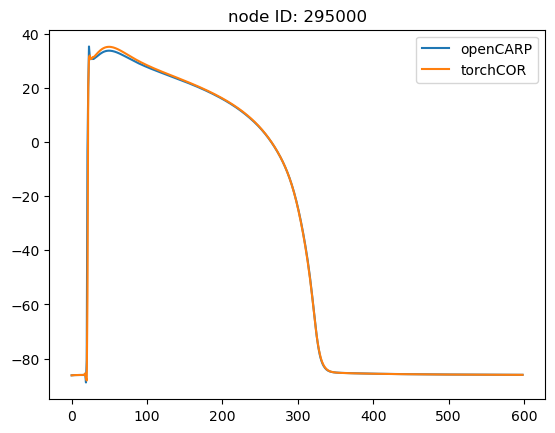

In [8]:
for node_id in range(0, 300000):
    carp = []
    cor = []
    largest_diff_node = node_id
    for i in range(599):
        carp.append(carp_solution[i][largest_diff_node])
        cor.append(cor_solution[i][largest_diff_node])
        
    plt.plot(carp, label="openCARP")
    plt.plot(cor, label="torchCOR")
    plt.title(f"node ID: {largest_diff_node}")
    plt.legend()

    plt.show()

In [11]:
diff_list = []
for i in range(599):
    # diff = np.linalg.norm(carp_solution[i] - cor_solution[i]) / np.linalg.norm(carp_solution[i])
    print((carp_solution[i] - cor_solution[i]).max())
    # diff_list.append(diff)

53.341957
57.887947
67.32339
59.389416
62.564774
164.1648
141.91394
128.03082
122.21707
123.90762
121.180954
120.84486
121.219894
120.55258
122.08105
123.080185
121.20858
122.34712
124.410065
122.448044
125.525246
127.25305
126.297356
123.62599
123.58948
124.82298
127.169846
123.5339
125.20247
125.53978
125.41516
124.50951
124.26143
125.557816
124.948685
126.888794
126.66196
127.4948
126.77988
128.01717
126.19183
128.0428
128.63441
128.86986
128.50024
127.66727
127.203156
130.43439
128.57837
127.49939
128.24269
127.65324
127.213425
127.40262
127.806656
129.55898
130.96062
130.37054
128.25908
129.24857
129.15466
129.76059
128.33041
128.97212
129.59283
128.59824
131.01743
128.64949
129.3907
128.47403
127.945526
129.35454
131.49315
130.42291
132.03444
127.34692
128.92726
128.13539
127.95322
128.80946
128.26736
128.33484
128.01628
128.37788
128.39574
128.80542
126.90463
127.34328
127.243805
126.97496
122.9268
4.8121376
2.3009243
2.0637817
1.755516
1.4140339
1.0118771
0.5819359
0.12130737
-

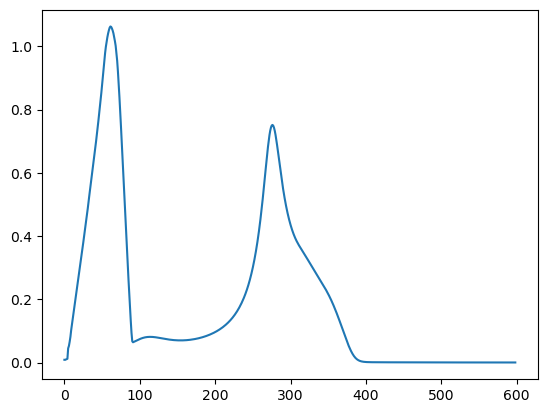

In [10]:
plt.plot(diff_list)